In [1]:
import os
import numpy as np
from PIL import Image
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers, callbacks
from tensorflow.keras.models import load_model


In [2]:
# Set base directory dynamically
CITYSCAPES_DIR = os.path.abspath("../data")  # Ensures the path is absolute

# Define image and label paths
IMAGES_DIR = os.path.join(CITYSCAPES_DIR, "leftImg8bit_trainvaltest", "leftImg8bit", "train")
LABELS_DIR = os.path.join(CITYSCAPES_DIR, "gtFine_trainvaltest", "gtFine", "train")
VAL_IMAGES_DIR = os.path.join(CITYSCAPES_DIR, "leftImg8bit_trainvaltest", "leftImg8bit", "val")
VAL_LABELS_DIR = os.path.join(CITYSCAPES_DIR, "gtFine_trainvaltest", "gtFine", "val")

# Constants
LIMIT_IMAGES = 100 # Number of images to sample
MAX_PIXELS = 10000  # Max number of pixels to process
LABEL_ID = 7  # Road label
BATCH_SIZE = 32 # Patch size
TARGET_SIZE = 256 # size of resample image width


In [3]:
def get_city_folders(directory):
    """Retrieve all city subfolders."""
    return [os.path.join(directory, city) for city in os.listdir(directory) if os.path.isdir(os.path.join(directory, city))]


In [4]:
def load_images_from_folder(images_dir, labels_dir):
    image_paths = []
    label_paths = []
    
    for filename in os.listdir(images_dir):
        if filename.endswith(".png"): 
            image_paths.append(os.path.join(images_dir, filename))
            label_paths.append(os.path.join(labels_dir, filename.replace("leftImg8bit", "gtFine").replace(".png", "_label.png")))
    
    return image_paths, label_paths

In [5]:
def get_image_label_pairs(images_dir, labels_dir):
    """Match RGB images with their corresponding label IDs."""
    image_label_pairs = []
    for city_folder in get_city_folders(images_dir):
        city_name = os.path.basename(city_folder)
        label_city_folder = os.path.join(labels_dir, city_name)

        for image_file in os.listdir(city_folder):
            if image_file.endswith("_leftImg8bit.png"):
                # Image path
                image_path = os.path.join(city_folder, image_file)
                # Corresponding label file
                label_file = image_file.replace("_leftImg8bit.png", "_gtFine_labelIds.png")
                label_path = os.path.join(label_city_folder, label_file)
                if os.path.exists(label_path):
                    image_label_pairs.append((image_path, label_path))
                    if len(image_label_pairs) >= LIMIT_IMAGES:  # Stop if limit is reached
                        return image_label_pairs
    return image_label_pairs


In [ ]:
import cv2
import numpy as np
import os
import tqdm

def image_label_generator(image_label_pairs, target_size=TARGET_SIZE, label_id=LABEL_ID, batch_size=BATCH_SIZE):
    while True:  # Keep generating images indefinitely
        X_batch = []  # List to store images in the current batch
        y_batch = []  # List to store labels in the current batch
        
        for image_path, label_path in tqdm.tqdm(image_label_pairs):
            # Read and resize the image
            image = cv2.imread(image_path, cv2.IMREAD_COLOR)
            h, w = image.shape[:2]

            # Calculate new height based on aspect ratio
            target_height = int((target_size / w) * h)

            # Resize the image
            image_resized = cv2.resize(image, (target_size, target_height))
            X_batch.append(image_resized)

            # Read and resize the label image
            label_img = cv2.imread(label_path, cv2.IMREAD_UNCHANGED)
            label_resized = cv2.resize(label_img, (target_size, target_height), interpolation=cv2.INTER_NEAREST)

            # Convert label to binary mask (for the target class)
            binary_label = (label_resized == label_id).astype(np.uint8)
            y_batch.append(binary_label)

            # If the batch size is met, yield the batch and reset the batch lists
            if len(X_batch) == batch_size:
                yield np.array(X_batch), np.expand_dims(np.array(y_batch), axis=-1)
                X_batch = []
                y_batch = []

        # If any remaining samples in the batch (less than batch_size), yield them
        if len(X_batch) > 0:
            yield np.array(X_batch), np.expand_dims(np.array(y_batch), axis=-1)


In [7]:
def extract_train_val_data_from_generator(target_size=TARGET_SIZE, batch_size=BATCH_SIZE):
    
    # Get training and validation image-label pairs
    train_image_label_pairs = get_image_label_pairs(IMAGES_DIR, LABELS_DIR)
    val_image_label_pairs = get_image_label_pairs(VAL_IMAGES_DIR, VAL_LABELS_DIR)

    # Create generators for both training and validation data
    train_generator = image_label_generator(
        train_image_label_pairs, 
        target_size=TARGET_SIZE, 
        label_id=LABEL_ID, 
        batch_size=batch_size
    )
    
    val_generator = image_label_generator(
        val_image_label_pairs, 
        target_size=TARGET_SIZE, 
        label_id=LABEL_ID, 
        batch_size=batch_size
    )

    # This will just return the generators as we will use them for training
    return train_generator, val_generator


In [8]:
STEPS_PER_EPOCH = 1000

train_generator, val_generator = extract_train_val_data_from_generator(target_size=TARGET_SIZE, batch_size=BATCH_SIZE)

In [9]:
from tensorflow.keras import layers, models

def build_fcn(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # Encoder (Feature Extraction)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)  # Downsample
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)  # Downsample
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)  # Downsample

    # Decoder (Upsampling)
    x = layers.Conv2DTranspose(128, (3, 3), strides=2, activation='relu', padding='same')(x)  # Upsample
    x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation='relu', padding='same')(x)  # Upsample
    x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation='relu', padding='same')(x)  # Upsample

    # Output Layer
    outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax' if num_classes > 1 else 'sigmoid')(x)

    # Model
    model = models.Model(inputs, outputs)
    return model


In [12]:
#model = load_model('model_fcn.keras')

In [ ]:
from tensorflow.keras import optimizers, callbacks

def train_image_classifier_with_generator(train_generator, val_generator, steps_per_epoch, validation_steps, epochs=20, batch_size=32):
    # Build the full-image classifier
    input_shape = (128, 256, 3)  # Adjust as per your image dimensions (example size)
    model = build_fcn(input_shape, num_classes=1) 

    # Compile the model
    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',  # Use 'categorical_crossentropy' for multi-class classification
        metrics=['accuracy']
    )

    # Define callbacks
    checkpoint_cb = callbacks.ModelCheckpoint("image_classifier_best.keras", save_best_only=True, monitor="val_loss", mode="min")
    early_stopping_cb = callbacks.EarlyStopping(patience=3, restore_best_weights=True, monitor="val_loss", mode="min")

    # Train the model using the generators
    history = model.fit(
        train_generator, 
        steps_per_epoch=steps_per_epoch,  # Number of steps per epoch (e.g., len(train_image_label_pairs) // batch_size)
        epochs=epochs,
        validation_data=val_generator,
        validation_steps=validation_steps,  # Number of steps for validation (similar to steps_per_epoch)
        callbacks=[checkpoint_cb, early_stopping_cb],
        verbose=1
    )

    return model, history

# Example usage:
epochs = 4
batch_size = 32
steps_per_epoch = 100  # Adjust this based on your dataset size and batch size
validation_steps = 10  # Same as steps_per_epoch for validation, adjust as needed

# Assuming train_generator and val_generator are defined and working with your image-label pairs
model, history = train_image_classifier_with_generator(
    train_generator, 
    val_generator, 
    steps_per_epoch=steps_per_epoch, 
    validation_steps=validation_steps, 
    epochs=epochs, 
    batch_size=batch_size
)

# Check the model summary after training
model.summary()

100%|██████████| 10/10 [00:00<00:00, 27.31it/s]


Epoch 1/4


 30%|███       | 3/10 [00:00<00:00, 24.79it/s]

  1/100 [..............................] - ETA: 1:03 - loss: 0.6839 - accuracy: 0.5516

  0%|          | 0/10 [00:00<?, ?it/s]

  2/100 [..............................] - ETA: 21s - loss: 0.6898 - accuracy: 0.5842 

  0%|          | 0/10 [00:00<?, ?it/s]

  3/100 [..............................] - ETA: 28s - loss: 0.6735 - accuracy: 0.5952

  0%|          | 0/10 [00:00<?, ?it/s]

  4/100 [>.............................] - ETA: 30s - loss: 0.6631 - accuracy: 0.6008

  0%|          | 0/10 [00:00<?, ?it/s]

  5/100 [>.............................] - ETA: 31s - loss: 0.6542 - accuracy: 0.6040

  0%|          | 0/10 [00:00<?, ?it/s]

  6/100 [>.............................] - ETA: 32s - loss: 0.6460 - accuracy: 0.6064

  0%|          | 0/10 [00:00<?, ?it/s]

  7/100 [=>............................] - ETA: 32s - loss: 0.6375 - accuracy: 0.6080

  0%|          | 0/10 [00:00<?, ?it/s]

  8/100 [=>............................] - ETA: 32s - loss: 0.6285 - accuracy: 0.6095

  0%|          | 0/10 [00:00<?, ?it/s]

  9/100 [=>............................] - ETA: 32s - loss: 0.6194 - accuracy: 0.6109

  0%|          | 0/10 [00:00<?, ?it/s]

 10/100 [==>...........................] - ETA: 32s - loss: 0.6105 - accuracy: 0.6123

  0%|          | 0/10 [00:00<?, ?it/s]

 11/100 [==>...........................] - ETA: 32s - loss: 0.6019 - accuracy: 0.6139

  0%|          | 0/10 [00:00<?, ?it/s]

 12/100 [==>...........................] - ETA: 32s - loss: 0.5936 - accuracy: 0.6161

  0%|          | 0/10 [00:00<?, ?it/s]

 13/100 [==>...........................] - ETA: 31s - loss: 0.5857 - accuracy: 0.6190

  0%|          | 0/10 [00:00<?, ?it/s]

 14/100 [===>..........................] - ETA: 31s - loss: 0.5781 - accuracy: 0.6238

  0%|          | 0/10 [00:00<?, ?it/s]

 15/100 [===>..........................] - ETA: 31s - loss: 0.5708 - accuracy: 0.6312

 30%|███       | 3/10 [00:00<00:00, 26.31it/s]

 16/100 [===>..........................] - ETA: 31s - loss: 0.5635 - accuracy: 0.6398

 30%|███       | 3/10 [00:00<00:00, 27.50it/s]

 17/100 [====>.........................] - ETA: 31s - loss: 0.5565 - accuracy: 0.6491

 30%|███       | 3/10 [00:00<00:00, 27.02it/s]

 18/100 [====>.........................] - ETA: 30s - loss: 0.5498 - accuracy: 0.6574

  0%|          | 0/10 [00:00<?, ?it/s]

 19/100 [====>.........................] - ETA: 29s - loss: 0.5441 - accuracy: 0.6666

  0%|          | 0/10 [00:00<?, ?it/s]

 20/100 [=====>........................] - ETA: 29s - loss: 0.5376 - accuracy: 0.6751

  0%|          | 0/10 [00:00<?, ?it/s]

 21/100 [=====>........................] - ETA: 29s - loss: 0.5323 - accuracy: 0.6815

  0%|          | 0/10 [00:00<?, ?it/s]

 22/100 [=====>........................] - ETA: 28s - loss: 0.5281 - accuracy: 0.6895

  0%|          | 0/10 [00:00<?, ?it/s]

 23/100 [=====>........................] - ETA: 28s - loss: 0.5235 - accuracy: 0.6972

  0%|          | 0/10 [00:00<?, ?it/s]

 24/100 [======>.......................] - ETA: 28s - loss: 0.5182 - accuracy: 0.7037

  0%|          | 0/10 [00:00<?, ?it/s]

 25/100 [======>.......................] - ETA: 27s - loss: 0.5136 - accuracy: 0.7095

  0%|          | 0/10 [00:00<?, ?it/s]

 26/100 [======>.......................] - ETA: 27s - loss: 0.5090 - accuracy: 0.7163

  0%|          | 0/10 [00:00<?, ?it/s]

 27/100 [=======>......................] - ETA: 27s - loss: 0.5051 - accuracy: 0.7224

  0%|          | 0/10 [00:00<?, ?it/s]

 28/100 [=======>......................] - ETA: 26s - loss: 0.5002 - accuracy: 0.7286

  0%|          | 0/10 [00:00<?, ?it/s]

 29/100 [=======>......................] - ETA: 26s - loss: 0.4968 - accuracy: 0.7329

 30%|███       | 3/10 [00:00<00:00, 26.30it/s]

 30/100 [========>.....................] - ETA: 26s - loss: 0.4921 - accuracy: 0.7385

 30%|███       | 3/10 [00:00<00:00, 24.00it/s]

 31/100 [========>.....................] - ETA: 26s - loss: 0.4885 - accuracy: 0.7432

 30%|███       | 3/10 [00:00<00:00, 25.08it/s]

 32/100 [========>.....................] - ETA: 25s - loss: 0.4842 - accuracy: 0.7480

  0%|          | 0/10 [00:00<?, ?it/s]

 33/100 [========>.....................] - ETA: 25s - loss: 0.4801 - accuracy: 0.7526

  0%|          | 0/10 [00:00<?, ?it/s]

 34/100 [=========>....................] - ETA: 24s - loss: 0.4758 - accuracy: 0.7570

  0%|          | 0/10 [00:00<?, ?it/s]

 35/100 [=========>....................] - ETA: 24s - loss: 0.4714 - accuracy: 0.7611

  0%|          | 0/10 [00:00<?, ?it/s]

 36/100 [=========>....................] - ETA: 24s - loss: 0.4672 - accuracy: 0.7647

  0%|          | 0/10 [00:00<?, ?it/s]

 37/100 [==========>...................] - ETA: 23s - loss: 0.4624 - accuracy: 0.7687

  0%|          | 0/10 [00:00<?, ?it/s]

 38/100 [==========>...................] - ETA: 23s - loss: 0.4580 - accuracy: 0.7723

  0%|          | 0/10 [00:00<?, ?it/s]

 39/100 [==========>...................] - ETA: 23s - loss: 0.4538 - accuracy: 0.7753

  0%|          | 0/10 [00:00<?, ?it/s]

 40/100 [===========>..................] - ETA: 22s - loss: 0.4491 - accuracy: 0.7786

  0%|          | 0/10 [00:00<?, ?it/s]

 41/100 [===========>..................] - ETA: 22s - loss: 0.4458 - accuracy: 0.7815

  0%|          | 0/10 [00:00<?, ?it/s]

 42/100 [===========>..................] - ETA: 22s - loss: 0.4431 - accuracy: 0.7836

  0%|          | 0/10 [00:00<?, ?it/s]

 43/100 [===========>..................] - ETA: 21s - loss: 0.4392 - accuracy: 0.7862

  0%|          | 0/10 [00:00<?, ?it/s]

 44/100 [============>.................] - ETA: 21s - loss: 0.4356 - accuracy: 0.7889

  0%|          | 0/10 [00:00<?, ?it/s]

 45/100 [============>.................] - ETA: 21s - loss: 0.4312 - accuracy: 0.7918

  0%|          | 0/10 [00:00<?, ?it/s]

 46/100 [============>.................] - ETA: 20s - loss: 0.4272 - accuracy: 0.7943

  0%|          | 0/10 [00:00<?, ?it/s]

 47/100 [=============>................] - ETA: 20s - loss: 0.4234 - accuracy: 0.7967

  0%|          | 0/10 [00:00<?, ?it/s]

 48/100 [=============>................] - ETA: 19s - loss: 0.4191 - accuracy: 0.7993

  0%|          | 0/10 [00:00<?, ?it/s]

 49/100 [=============>................] - ETA: 19s - loss: 0.4155 - accuracy: 0.8016

 30%|███       | 3/10 [00:00<00:00, 26.31it/s]

 50/100 [==============>...............] - ETA: 19s - loss: 0.4115 - accuracy: 0.8041

 30%|███       | 3/10 [00:00<00:00, 26.90it/s]

 51/100 [==============>...............] - ETA: 18s - loss: 0.4078 - accuracy: 0.8063

 30%|███       | 3/10 [00:00<00:00, 26.76it/s]

 52/100 [==============>...............] - ETA: 18s - loss: 0.4040 - accuracy: 0.8085

  0%|          | 0/10 [00:00<?, ?it/s]

 53/100 [==============>...............] - ETA: 17s - loss: 0.4002 - accuracy: 0.8108

  0%|          | 0/10 [00:00<?, ?it/s]

 54/100 [===============>..............] - ETA: 17s - loss: 0.3966 - accuracy: 0.8129

  0%|          | 0/10 [00:00<?, ?it/s]

 55/100 [===============>..............] - ETA: 17s - loss: 0.3928 - accuracy: 0.8150

  0%|          | 0/10 [00:00<?, ?it/s]

 56/100 [===============>..............] - ETA: 16s - loss: 0.3893 - accuracy: 0.8170

  0%|          | 0/10 [00:00<?, ?it/s]

 57/100 [================>.............] - ETA: 16s - loss: 0.3857 - accuracy: 0.8190

  0%|          | 0/10 [00:00<?, ?it/s]

 58/100 [================>.............] - ETA: 16s - loss: 0.3822 - accuracy: 0.8210

  0%|          | 0/10 [00:00<?, ?it/s]

 59/100 [================>.............] - ETA: 15s - loss: 0.3789 - accuracy: 0.8228

  0%|          | 0/10 [00:00<?, ?it/s]

 60/100 [=================>............] - ETA: 15s - loss: 0.3754 - accuracy: 0.8248

  0%|          | 0/10 [00:00<?, ?it/s]

 61/100 [=================>............] - ETA: 14s - loss: 0.3723 - accuracy: 0.8265

  0%|          | 0/10 [00:00<?, ?it/s]

 62/100 [=================>............] - ETA: 14s - loss: 0.3693 - accuracy: 0.8282

  0%|          | 0/10 [00:00<?, ?it/s]

 63/100 [=================>............] - ETA: 14s - loss: 0.3659 - accuracy: 0.8301

  0%|          | 0/10 [00:00<?, ?it/s]

 64/100 [==================>...........] - ETA: 13s - loss: 0.3631 - accuracy: 0.8316

  0%|          | 0/10 [00:00<?, ?it/s]

 65/100 [==================>...........] - ETA: 13s - loss: 0.3602 - accuracy: 0.8332

  0%|          | 0/10 [00:00<?, ?it/s]

 66/100 [==================>...........] - ETA: 12s - loss: 0.3571 - accuracy: 0.8349

  0%|          | 0/10 [00:00<?, ?it/s]

 67/100 [===================>..........] - ETA: 12s - loss: 0.3544 - accuracy: 0.8364

  0%|          | 0/10 [00:00<?, ?it/s]

 68/100 [===================>..........] - ETA: 12s - loss: 0.3513 - accuracy: 0.8381

  0%|          | 0/10 [00:00<?, ?it/s]

 69/100 [===================>..........] - ETA: 11s - loss: 0.3485 - accuracy: 0.8396

  0%|          | 0/10 [00:00<?, ?it/s]

 70/100 [====================>.........] - ETA: 11s - loss: 0.3455 - accuracy: 0.8412

  0%|          | 0/10 [00:00<?, ?it/s]

 71/100 [====================>.........] - ETA: 11s - loss: 0.3427 - accuracy: 0.8427

  0%|          | 0/10 [00:00<?, ?it/s]

 72/100 [====================>.........] - ETA: 10s - loss: 0.3400 - accuracy: 0.8441

  0%|          | 0/10 [00:00<?, ?it/s]

 73/100 [====================>.........] - ETA: 10s - loss: 0.3371 - accuracy: 0.8456

  0%|          | 0/10 [00:00<?, ?it/s]

 74/100 [=====================>........] - ETA: 9s - loss: 0.3345 - accuracy: 0.8470 

  0%|          | 0/10 [00:00<?, ?it/s]

 75/100 [=====================>........] - ETA: 9s - loss: 0.3317 - accuracy: 0.8484

  0%|          | 0/10 [00:00<?, ?it/s]

 76/100 [=====================>........] - ETA: 9s - loss: 0.3291 - accuracy: 0.8498

  0%|          | 0/10 [00:00<?, ?it/s]

 77/100 [======================>.......] - ETA: 8s - loss: 0.3265 - accuracy: 0.8512

  0%|          | 0/10 [00:00<?, ?it/s]

 78/100 [======================>.......] - ETA: 8s - loss: 0.3238 - accuracy: 0.8525

  0%|          | 0/10 [00:00<?, ?it/s]

 79/100 [======================>.......] - ETA: 8s - loss: 0.3212 - accuracy: 0.8539

  0%|          | 0/10 [00:00<?, ?it/s]

 80/100 [=======================>......] - ETA: 7s - loss: 0.3187 - accuracy: 0.8552

  0%|          | 0/10 [00:00<?, ?it/s]

 81/100 [=======================>......] - ETA: 7s - loss: 0.3162 - accuracy: 0.8565

  0%|          | 0/10 [00:00<?, ?it/s]

 82/100 [=======================>......] - ETA: 6s - loss: 0.3137 - accuracy: 0.8577

  0%|          | 0/10 [00:00<?, ?it/s]

 83/100 [=======================>......] - ETA: 6s - loss: 0.3112 - accuracy: 0.8590

  0%|          | 0/10 [00:00<?, ?it/s]

 84/100 [========================>.....] - ETA: 6s - loss: 0.3087 - accuracy: 0.8602

  0%|          | 0/10 [00:00<?, ?it/s]

 85/100 [========================>.....] - ETA: 5s - loss: 0.3063 - accuracy: 0.8615

  0%|          | 0/10 [00:00<?, ?it/s]

 86/100 [========================>.....] - ETA: 5s - loss: 0.3039 - accuracy: 0.8626

  0%|          | 0/10 [00:00<?, ?it/s]

 87/100 [=========================>....] - ETA: 4s - loss: 0.3015 - accuracy: 0.8638

  0%|          | 0/10 [00:00<?, ?it/s]

 88/100 [=========================>....] - ETA: 4s - loss: 0.2991 - accuracy: 0.8650

  0%|          | 0/10 [00:00<?, ?it/s]

 89/100 [=========================>....] - ETA: 4s - loss: 0.2969 - accuracy: 0.8661

  0%|          | 0/10 [00:00<?, ?it/s]

 90/100 [==========================>...] - ETA: 3s - loss: 0.2951 - accuracy: 0.8670

  0%|          | 0/10 [00:00<?, ?it/s]

 91/100 [==========================>...] - ETA: 3s - loss: 0.2952 - accuracy: 0.8671

  0%|          | 0/10 [00:00<?, ?it/s]

 92/100 [==========================>...] - ETA: 3s - loss: 0.2994 - accuracy: 0.8665

  0%|          | 0/10 [00:00<?, ?it/s]

 93/100 [==========================>...] - ETA: 2s - loss: 0.2989 - accuracy: 0.8669

  0%|          | 0/10 [00:00<?, ?it/s]

 94/100 [===========================>..] - ETA: 2s - loss: 0.2990 - accuracy: 0.8672

  0%|          | 0/10 [00:00<?, ?it/s]

 95/100 [===========================>..] - ETA: 1s - loss: 0.2978 - accuracy: 0.8679

  0%|          | 0/10 [00:00<?, ?it/s]

 96/100 [===========================>..] - ETA: 1s - loss: 0.2970 - accuracy: 0.8683

  0%|          | 0/10 [00:00<?, ?it/s]

 97/100 [============================>.] - ETA: 1s - loss: 0.2964 - accuracy: 0.8687

  0%|          | 0/10 [00:00<?, ?it/s]

 98/100 [============================>.] - ETA: 0s - loss: 0.2957 - accuracy: 0.8690

 30%|███       | 3/10 [00:00<00:00, 25.50it/s]

 99/100 [============================>.] - ETA: 0s - loss: 0.2952 - accuracy: 0.8693

 30%|███       | 3/10 [00:00<00:00, 26.32it/s]

100/100 [==============================] - ETA: 0s - loss: 0.2946 - accuracy: 0.8697

100%|██████████| 10/10 [00:00<00:00, 26.17it/s]

100/100 [==============================] - 43s 427ms/step - loss: 0.2946 - accuracy: 0.8697 - val_loss: 0.5127 - val_accuracy: 0.8042


Epoch 2/4


 30%|███       | 3/10 [00:00<00:00, 26.29it/s]

  1/100 [..............................] - ETA: 15s - loss: 0.2186 - accuracy: 0.9191

 30%|███       | 3/10 [00:00<00:00, 25.87it/s]

  2/100 [..............................] - ETA: 36s - loss: 0.2140 - accuracy: 0.9211

  0%|          | 0/10 [00:00<?, ?it/s]

  3/100 [..............................] - ETA: 31s - loss: 0.2111 - accuracy: 0.9220

  0%|          | 0/10 [00:00<?, ?it/s]

  4/100 [>.............................] - ETA: 32s - loss: 0.2090 - accuracy: 0.9225

  0%|          | 0/10 [00:00<?, ?it/s]

  5/100 [>.............................] - ETA: 33s - loss: 0.2072 - accuracy: 0.9231

  0%|          | 0/10 [00:00<?, ?it/s]

  6/100 [>.............................] - ETA: 33s - loss: 0.2052 - accuracy: 0.9237

  0%|          | 0/10 [00:00<?, ?it/s]

  7/100 [=>............................] - ETA: 33s - loss: 0.2029 - accuracy: 0.9246

  0%|          | 0/10 [00:00<?, ?it/s]

  8/100 [=>............................] - ETA: 33s - loss: 0.2005 - accuracy: 0.9257

  0%|          | 0/10 [00:00<?, ?it/s]

  9/100 [=>............................] - ETA: 33s - loss: 0.1980 - accuracy: 0.9267

  0%|          | 0/10 [00:00<?, ?it/s]

 10/100 [==>...........................] - ETA: 33s - loss: 0.1956 - accuracy: 0.9277

  0%|          | 0/10 [00:00<?, ?it/s]

 11/100 [==>...........................] - ETA: 32s - loss: 0.1933 - accuracy: 0.9285

  0%|          | 0/10 [00:00<?, ?it/s]

 12/100 [==>...........................] - ETA: 32s - loss: 0.1911 - accuracy: 0.9293

  0%|          | 0/10 [00:00<?, ?it/s]

 13/100 [==>...........................] - ETA: 32s - loss: 0.1890 - accuracy: 0.9300

  0%|          | 0/10 [00:00<?, ?it/s]

 14/100 [===>..........................] - ETA: 31s - loss: 0.1869 - accuracy: 0.9307

  0%|          | 0/10 [00:00<?, ?it/s]

 15/100 [===>..........................] - ETA: 31s - loss: 0.1849 - accuracy: 0.9315

  0%|          | 0/10 [00:00<?, ?it/s]

 16/100 [===>..........................] - ETA: 31s - loss: 0.1829 - accuracy: 0.9322

  0%|          | 0/10 [00:00<?, ?it/s]

 17/100 [====>.........................] - ETA: 30s - loss: 0.1809 - accuracy: 0.9330

  0%|          | 0/10 [00:00<?, ?it/s]

 18/100 [====>.........................] - ETA: 30s - loss: 0.1789 - accuracy: 0.9338

  0%|          | 0/10 [00:00<?, ?it/s]

 19/100 [====>.........................] - ETA: 30s - loss: 0.1769 - accuracy: 0.9346

  0%|          | 0/10 [00:00<?, ?it/s]

 20/100 [=====>........................] - ETA: 29s - loss: 0.1750 - accuracy: 0.9354

  0%|          | 0/10 [00:00<?, ?it/s]

 21/100 [=====>........................] - ETA: 29s - loss: 0.1731 - accuracy: 0.9362

  0%|          | 0/10 [00:00<?, ?it/s]

 22/100 [=====>........................] - ETA: 29s - loss: 0.1712 - accuracy: 0.9371

  0%|          | 0/10 [00:00<?, ?it/s]

 23/100 [=====>........................] - ETA: 28s - loss: 0.1694 - accuracy: 0.9379

  0%|          | 0/10 [00:00<?, ?it/s]

 24/100 [======>.......................] - ETA: 28s - loss: 0.1676 - accuracy: 0.9387

  0%|          | 0/10 [00:00<?, ?it/s]

 25/100 [======>.......................] - ETA: 28s - loss: 0.1658 - accuracy: 0.9395

  0%|          | 0/10 [00:00<?, ?it/s]

 26/100 [======>.......................] - ETA: 27s - loss: 0.1640 - accuracy: 0.9402

  0%|          | 0/10 [00:00<?, ?it/s]

 27/100 [=======>......................] - ETA: 27s - loss: 0.1622 - accuracy: 0.9410

  0%|          | 0/10 [00:00<?, ?it/s]

 28/100 [=======>......................] - ETA: 26s - loss: 0.1605 - accuracy: 0.9417

  0%|          | 0/10 [00:00<?, ?it/s]

 29/100 [=======>......................] - ETA: 26s - loss: 0.1587 - accuracy: 0.9424

  0%|          | 0/10 [00:00<?, ?it/s]

 30/100 [========>.....................] - ETA: 26s - loss: 0.1571 - accuracy: 0.9430

  0%|          | 0/10 [00:00<?, ?it/s]

 31/100 [========>.....................] - ETA: 25s - loss: 0.1555 - accuracy: 0.9437

  0%|          | 0/10 [00:00<?, ?it/s]

 32/100 [========>.....................] - ETA: 25s - loss: 0.1541 - accuracy: 0.9442

  0%|          | 0/10 [00:00<?, ?it/s]

 33/100 [========>.....................] - ETA: 25s - loss: 0.1527 - accuracy: 0.9447

  0%|          | 0/10 [00:00<?, ?it/s]

 34/100 [=========>....................] - ETA: 24s - loss: 0.1511 - accuracy: 0.9453

  0%|          | 0/10 [00:00<?, ?it/s]

 35/100 [=========>....................] - ETA: 24s - loss: 0.1495 - accuracy: 0.9459

  0%|          | 0/10 [00:00<?, ?it/s]

 36/100 [=========>....................] - ETA: 24s - loss: 0.1481 - accuracy: 0.9464

  0%|          | 0/10 [00:00<?, ?it/s]

 37/100 [==========>...................] - ETA: 23s - loss: 0.1466 - accuracy: 0.9469

  0%|          | 0/10 [00:00<?, ?it/s]

 38/100 [==========>...................] - ETA: 23s - loss: 0.1451 - accuracy: 0.9475

  0%|          | 0/10 [00:00<?, ?it/s]

 39/100 [==========>...................] - ETA: 22s - loss: 0.1437 - accuracy: 0.9480

  0%|          | 0/10 [00:00<?, ?it/s]

 40/100 [===========>..................] - ETA: 22s - loss: 0.1425 - accuracy: 0.9484

  0%|          | 0/10 [00:00<?, ?it/s]

 41/100 [===========>..................] - ETA: 22s - loss: 0.1411 - accuracy: 0.9489

  0%|          | 0/10 [00:00<?, ?it/s]

 42/100 [===========>..................] - ETA: 21s - loss: 0.1397 - accuracy: 0.9494

  0%|          | 0/10 [00:00<?, ?it/s]

 43/100 [===========>..................] - ETA: 21s - loss: 0.1384 - accuracy: 0.9498

  0%|          | 0/10 [00:00<?, ?it/s]

 44/100 [============>.................] - ETA: 21s - loss: 0.1371 - accuracy: 0.9503

 30%|███       | 3/10 [00:00<00:00, 27.27it/s]

 45/100 [============>.................] - ETA: 20s - loss: 0.1360 - accuracy: 0.9507

 30%|███       | 3/10 [00:00<00:00, 27.00it/s]

 46/100 [============>.................] - ETA: 20s - loss: 0.1347 - accuracy: 0.9511

 30%|███       | 3/10 [00:00<00:00, 25.55it/s]

 47/100 [=============>................] - ETA: 19s - loss: 0.1334 - accuracy: 0.9516

  0%|          | 0/10 [00:00<?, ?it/s]

 48/100 [=============>................] - ETA: 19s - loss: 0.1322 - accuracy: 0.9520

  0%|          | 0/10 [00:00<?, ?it/s]

 49/100 [=============>................] - ETA: 19s - loss: 0.1310 - accuracy: 0.9524

  0%|          | 0/10 [00:00<?, ?it/s]

 50/100 [==============>...............] - ETA: 18s - loss: 0.1299 - accuracy: 0.9528

  0%|          | 0/10 [00:00<?, ?it/s]

 51/100 [==============>...............] - ETA: 18s - loss: 0.1288 - accuracy: 0.9532

  0%|          | 0/10 [00:00<?, ?it/s]

 52/100 [==============>...............] - ETA: 17s - loss: 0.1276 - accuracy: 0.9536

  0%|          | 0/10 [00:00<?, ?it/s]

 53/100 [==============>...............] - ETA: 17s - loss: 0.1264 - accuracy: 0.9540

  0%|          | 0/10 [00:00<?, ?it/s]

 54/100 [===============>..............] - ETA: 17s - loss: 0.1252 - accuracy: 0.9544

  0%|          | 0/10 [00:00<?, ?it/s]

 55/100 [===============>..............] - ETA: 16s - loss: 0.1241 - accuracy: 0.9548

  0%|          | 0/10 [00:00<?, ?it/s]

 56/100 [===============>..............] - ETA: 16s - loss: 0.1231 - accuracy: 0.9552

  0%|          | 0/10 [00:00<?, ?it/s]

 57/100 [================>.............] - ETA: 16s - loss: 0.1223 - accuracy: 0.9554

  0%|          | 0/10 [00:00<?, ?it/s]

 58/100 [================>.............] - ETA: 15s - loss: 0.1220 - accuracy: 0.9555

  0%|          | 0/10 [00:00<?, ?it/s]

 59/100 [================>.............] - ETA: 15s - loss: 0.1235 - accuracy: 0.9551

  0%|          | 0/10 [00:00<?, ?it/s]

 60/100 [=================>............] - ETA: 15s - loss: 0.1233 - accuracy: 0.9551

  0%|          | 0/10 [00:00<?, ?it/s]

 61/100 [=================>............] - ETA: 14s - loss: 0.1227 - accuracy: 0.9553

  0%|          | 0/10 [00:00<?, ?it/s]

 62/100 [=================>............] - ETA: 14s - loss: 0.1223 - accuracy: 0.9555

  0%|          | 0/10 [00:00<?, ?it/s]

 63/100 [=================>............] - ETA: 13s - loss: 0.1217 - accuracy: 0.9556

  0%|          | 0/10 [00:00<?, ?it/s]

 64/100 [==================>...........] - ETA: 13s - loss: 0.1210 - accuracy: 0.9559

  0%|          | 0/10 [00:00<?, ?it/s]

 65/100 [==================>...........] - ETA: 13s - loss: 0.1206 - accuracy: 0.9560

  0%|          | 0/10 [00:00<?, ?it/s]

 66/100 [==================>...........] - ETA: 12s - loss: 0.1200 - accuracy: 0.9562

  0%|          | 0/10 [00:00<?, ?it/s]

 67/100 [===================>..........] - ETA: 12s - loss: 0.1196 - accuracy: 0.9563

  0%|          | 0/10 [00:00<?, ?it/s]

 68/100 [===================>..........] - ETA: 12s - loss: 0.1190 - accuracy: 0.9565

  0%|          | 0/10 [00:00<?, ?it/s]

 69/100 [===================>..........] - ETA: 11s - loss: 0.1184 - accuracy: 0.9568

  0%|          | 0/10 [00:00<?, ?it/s]

 70/100 [====================>.........] - ETA: 11s - loss: 0.1179 - accuracy: 0.9569

  0%|          | 0/10 [00:00<?, ?it/s]

 71/100 [====================>.........] - ETA: 10s - loss: 0.1172 - accuracy: 0.9572

  0%|          | 0/10 [00:00<?, ?it/s]

 72/100 [====================>.........] - ETA: 10s - loss: 0.1166 - accuracy: 0.9574

  0%|          | 0/10 [00:00<?, ?it/s]

 73/100 [====================>.........] - ETA: 10s - loss: 0.1160 - accuracy: 0.9576

  0%|          | 0/10 [00:00<?, ?it/s]

 74/100 [=====================>........] - ETA: 9s - loss: 0.1153 - accuracy: 0.9579 

  0%|          | 0/10 [00:00<?, ?it/s]

 75/100 [=====================>........] - ETA: 9s - loss: 0.1147 - accuracy: 0.9581

  0%|          | 0/10 [00:00<?, ?it/s]

 76/100 [=====================>........] - ETA: 9s - loss: 0.1140 - accuracy: 0.9583

  0%|          | 0/10 [00:00<?, ?it/s]

 77/100 [======================>.......] - ETA: 8s - loss: 0.1133 - accuracy: 0.9585

  0%|          | 0/10 [00:00<?, ?it/s]

 78/100 [======================>.......] - ETA: 8s - loss: 0.1126 - accuracy: 0.9588

  0%|          | 0/10 [00:00<?, ?it/s]

 79/100 [======================>.......] - ETA: 7s - loss: 0.1120 - accuracy: 0.9590

  0%|          | 0/10 [00:00<?, ?it/s]

 80/100 [=======================>......] - ETA: 7s - loss: 0.1113 - accuracy: 0.9593

  0%|          | 0/10 [00:00<?, ?it/s]

 81/100 [=======================>......] - ETA: 7s - loss: 0.1106 - accuracy: 0.9595

  0%|          | 0/10 [00:00<?, ?it/s]

 82/100 [=======================>......] - ETA: 6s - loss: 0.1099 - accuracy: 0.9598

  0%|          | 0/10 [00:00<?, ?it/s]

 83/100 [=======================>......] - ETA: 6s - loss: 0.1092 - accuracy: 0.9600

 30%|███       | 3/10 [00:00<00:00, 24.89it/s]

 84/100 [========================>.....] - ETA: 6s - loss: 0.1086 - accuracy: 0.9603

 30%|███       | 3/10 [00:00<00:00, 26.66it/s]

 85/100 [========================>.....] - ETA: 5s - loss: 0.1079 - accuracy: 0.9605

 30%|███       | 3/10 [00:00<00:00, 26.54it/s]

 86/100 [========================>.....] - ETA: 5s - loss: 0.1072 - accuracy: 0.9608

 30%|███       | 3/10 [00:00<00:00, 25.86it/s]

 87/100 [=========================>....] - ETA: 4s - loss: 0.1066 - accuracy: 0.9610

 30%|███       | 3/10 [00:00<00:00, 24.29it/s]

 88/100 [=========================>....] - ETA: 4s - loss: 0.1059 - accuracy: 0.9612

 30%|███       | 3/10 [00:00<00:00, 24.07it/s]

 89/100 [=========================>....] - ETA: 4s - loss: 0.1052 - accuracy: 0.9615

 30%|███       | 3/10 [00:00<00:00, 26.90it/s]

 90/100 [==========================>...] - ETA: 3s - loss: 0.1046 - accuracy: 0.9617

 30%|███       | 3/10 [00:00<00:00, 26.09it/s]

 91/100 [==========================>...] - ETA: 3s - loss: 0.1039 - accuracy: 0.9619

  0%|          | 0/10 [00:00<?, ?it/s]

 92/100 [==========================>...] - ETA: 3s - loss: 0.1033 - accuracy: 0.9622

  0%|          | 0/10 [00:00<?, ?it/s]

 93/100 [==========================>...] - ETA: 2s - loss: 0.1027 - accuracy: 0.9624

  0%|          | 0/10 [00:00<?, ?it/s]

 94/100 [===========================>..] - ETA: 2s - loss: 0.1020 - accuracy: 0.9626

  0%|          | 0/10 [00:00<?, ?it/s]

 95/100 [===========================>..] - ETA: 1s - loss: 0.1014 - accuracy: 0.9628

  0%|          | 0/10 [00:00<?, ?it/s]

 96/100 [===========================>..] - ETA: 1s - loss: 0.1008 - accuracy: 0.9631

  0%|          | 0/10 [00:00<?, ?it/s]

 97/100 [============================>.] - ETA: 1s - loss: 0.1001 - accuracy: 0.9633

  0%|          | 0/10 [00:00<?, ?it/s]

 98/100 [============================>.] - ETA: 0s - loss: 0.0995 - accuracy: 0.9635

  0%|          | 0/10 [00:00<?, ?it/s]

 99/100 [============================>.] - ETA: 0s - loss: 0.0989 - accuracy: 0.9637

  0%|          | 0/10 [00:00<?, ?it/s]

100/100 [==============================] - ETA: 0s - loss: 0.0983 - accuracy: 0.9640

100%|██████████| 10/10 [00:00<00:00, 26.07it/s]

100/100 [==============================] - 42s 423ms/step - loss: 0.0983 - accuracy: 0.9640 - val_loss: 1.3802 - val_accuracy: 0.7487
Epoch 3/4



 60%|██████    | 6/10 [00:00<00:00, 27.02it/s]

  1/100 [..............................] - ETA: 27s - loss: 0.0376 - accuracy: 0.9857

  0%|          | 0/10 [00:00<?, ?it/s]

  2/100 [..............................] - ETA: 11s - loss: 0.0376 - accuracy: 0.9857

  0%|          | 0/10 [00:00<?, ?it/s]

  3/100 [..............................] - ETA: 24s - loss: 0.0372 - accuracy: 0.9859

  0%|          | 0/10 [00:00<?, ?it/s]

  4/100 [>.............................] - ETA: 27s - loss: 0.0368 - accuracy: 0.9861

  0%|          | 0/10 [00:00<?, ?it/s]

  5/100 [>.............................] - ETA: 29s - loss: 0.0365 - accuracy: 0.9862

  0%|          | 0/10 [00:00<?, ?it/s]

  6/100 [>.............................] - ETA: 30s - loss: 0.0362 - accuracy: 0.9864

  0%|          | 0/10 [00:00<?, ?it/s]

  7/100 [=>............................] - ETA: 31s - loss: 0.0358 - accuracy: 0.9865

  0%|          | 0/10 [00:00<?, ?it/s]

  8/100 [=>............................] - ETA: 31s - loss: 0.0356 - accuracy: 0.9866

  0%|          | 0/10 [00:00<?, ?it/s]

  9/100 [=>............................] - ETA: 31s - loss: 0.0353 - accuracy: 0.9867

  0%|          | 0/10 [00:00<?, ?it/s]

 10/100 [==>...........................] - ETA: 31s - loss: 0.0350 - accuracy: 0.9869

  0%|          | 0/10 [00:00<?, ?it/s]

 11/100 [==>...........................] - ETA: 31s - loss: 0.0347 - accuracy: 0.9870

  0%|          | 0/10 [00:00<?, ?it/s]

 12/100 [==>...........................] - ETA: 31s - loss: 0.0345 - accuracy: 0.9871

  0%|          | 0/10 [00:00<?, ?it/s]

 13/100 [==>...........................] - ETA: 31s - loss: 0.0342 - accuracy: 0.9872

  0%|          | 0/10 [00:00<?, ?it/s]

 14/100 [===>..........................] - ETA: 31s - loss: 0.0339 - accuracy: 0.9873

  0%|          | 0/10 [00:00<?, ?it/s]

 15/100 [===>..........................] - ETA: 31s - loss: 0.0337 - accuracy: 0.9874

  0%|          | 0/10 [00:00<?, ?it/s]

 16/100 [===>..........................] - ETA: 30s - loss: 0.0334 - accuracy: 0.9876

  0%|          | 0/10 [00:00<?, ?it/s]

 17/100 [====>.........................] - ETA: 30s - loss: 0.0332 - accuracy: 0.9877

  0%|          | 0/10 [00:00<?, ?it/s]

 18/100 [====>.........................] - ETA: 30s - loss: 0.0329 - accuracy: 0.9877

  0%|          | 0/10 [00:00<?, ?it/s]

 19/100 [====>.........................] - ETA: 29s - loss: 0.0327 - accuracy: 0.9878

  0%|          | 0/10 [00:00<?, ?it/s]

 20/100 [=====>........................] - ETA: 29s - loss: 0.0325 - accuracy: 0.9879

  0%|          | 0/10 [00:00<?, ?it/s]

 21/100 [=====>........................] - ETA: 29s - loss: 0.0323 - accuracy: 0.9880

  0%|          | 0/10 [00:00<?, ?it/s]

 22/100 [=====>........................] - ETA: 28s - loss: 0.0320 - accuracy: 0.9881

  0%|          | 0/10 [00:00<?, ?it/s]

 23/100 [=====>........................] - ETA: 28s - loss: 0.0319 - accuracy: 0.9882

  0%|          | 0/10 [00:00<?, ?it/s]

 24/100 [======>.......................] - ETA: 28s - loss: 0.0317 - accuracy: 0.9882

  0%|          | 0/10 [00:00<?, ?it/s]

 25/100 [======>.......................] - ETA: 27s - loss: 0.0317 - accuracy: 0.9882

  0%|          | 0/10 [00:00<?, ?it/s]

 26/100 [======>.......................] - ETA: 27s - loss: 0.0319 - accuracy: 0.9881

  0%|          | 0/10 [00:00<?, ?it/s]

 27/100 [=======>......................] - ETA: 27s - loss: 0.0322 - accuracy: 0.9879

  0%|          | 0/10 [00:00<?, ?it/s]

 28/100 [=======>......................] - ETA: 26s - loss: 0.0324 - accuracy: 0.9878

  0%|          | 0/10 [00:00<?, ?it/s]

 29/100 [=======>......................] - ETA: 26s - loss: 0.0323 - accuracy: 0.9879

  0%|          | 0/10 [00:00<?, ?it/s]

 30/100 [========>.....................] - ETA: 26s - loss: 0.0321 - accuracy: 0.9879

  0%|          | 0/10 [00:00<?, ?it/s]

 31/100 [========>.....................] - ETA: 25s - loss: 0.0323 - accuracy: 0.9879

 30%|███       | 3/10 [00:00<00:00, 26.78it/s]

 32/100 [========>.....................] - ETA: 25s - loss: 0.0327 - accuracy: 0.9877

 30%|███       | 3/10 [00:00<00:00, 23.07it/s]

 33/100 [========>.....................] - ETA: 25s - loss: 0.0327 - accuracy: 0.9876

 30%|███       | 3/10 [00:00<00:00, 27.01it/s]

 34/100 [=========>....................] - ETA: 24s - loss: 0.0326 - accuracy: 0.9876

 30%|███       | 3/10 [00:00<00:00, 26.85it/s]

 35/100 [=========>....................] - ETA: 24s - loss: 0.0327 - accuracy: 0.9876

 30%|███       | 3/10 [00:00<00:00, 24.79it/s]

 36/100 [=========>....................] - ETA: 24s - loss: 0.0327 - accuracy: 0.9876

  0%|          | 0/10 [00:00<?, ?it/s]

 37/100 [==========>...................] - ETA: 23s - loss: 0.0325 - accuracy: 0.9877

  0%|          | 0/10 [00:00<?, ?it/s]

 38/100 [==========>...................] - ETA: 23s - loss: 0.0324 - accuracy: 0.9877

  0%|          | 0/10 [00:00<?, ?it/s]

 39/100 [==========>...................] - ETA: 22s - loss: 0.0322 - accuracy: 0.9878

  0%|          | 0/10 [00:00<?, ?it/s]

 40/100 [===========>..................] - ETA: 22s - loss: 0.0321 - accuracy: 0.9879

 30%|███       | 3/10 [00:00<00:00, 26.18it/s]

 41/100 [===========>..................] - ETA: 22s - loss: 0.0319 - accuracy: 0.9879

  0%|          | 0/10 [00:00<?, ?it/s]

 42/100 [===========>..................] - ETA: 21s - loss: 0.0317 - accuracy: 0.9880

  0%|          | 0/10 [00:00<?, ?it/s]

 43/100 [===========>..................] - ETA: 21s - loss: 0.0316 - accuracy: 0.9881

  0%|          | 0/10 [00:00<?, ?it/s]

 44/100 [============>.................] - ETA: 21s - loss: 0.0314 - accuracy: 0.9881

  0%|          | 0/10 [00:00<?, ?it/s]

 45/100 [============>.................] - ETA: 20s - loss: 0.0312 - accuracy: 0.9882

  0%|          | 0/10 [00:00<?, ?it/s]

 46/100 [============>.................] - ETA: 20s - loss: 0.0311 - accuracy: 0.9883

  0%|          | 0/10 [00:00<?, ?it/s]

 47/100 [=============>................] - ETA: 19s - loss: 0.0309 - accuracy: 0.9883

  0%|          | 0/10 [00:00<?, ?it/s]

 48/100 [=============>................] - ETA: 19s - loss: 0.0307 - accuracy: 0.9884

  0%|          | 0/10 [00:00<?, ?it/s]

 49/100 [=============>................] - ETA: 19s - loss: 0.0306 - accuracy: 0.9885

  0%|          | 0/10 [00:00<?, ?it/s]

 50/100 [==============>...............] - ETA: 18s - loss: 0.0304 - accuracy: 0.9885

  0%|          | 0/10 [00:00<?, ?it/s]

 51/100 [==============>...............] - ETA: 18s - loss: 0.0302 - accuracy: 0.9886

  0%|          | 0/10 [00:00<?, ?it/s]

 52/100 [==============>...............] - ETA: 18s - loss: 0.0301 - accuracy: 0.9887

  0%|          | 0/10 [00:00<?, ?it/s]

 53/100 [==============>...............] - ETA: 17s - loss: 0.0299 - accuracy: 0.9887

  0%|          | 0/10 [00:00<?, ?it/s]

 54/100 [===============>..............] - ETA: 17s - loss: 0.0298 - accuracy: 0.9888

  0%|          | 0/10 [00:00<?, ?it/s]

 55/100 [===============>..............] - ETA: 16s - loss: 0.0296 - accuracy: 0.9889

  0%|          | 0/10 [00:00<?, ?it/s]

 56/100 [===============>..............] - ETA: 16s - loss: 0.0294 - accuracy: 0.9889

  0%|          | 0/10 [00:00<?, ?it/s]

 57/100 [================>.............] - ETA: 16s - loss: 0.0292 - accuracy: 0.9890

  0%|          | 0/10 [00:00<?, ?it/s]

 58/100 [================>.............] - ETA: 15s - loss: 0.0291 - accuracy: 0.9891

  0%|          | 0/10 [00:00<?, ?it/s]

 59/100 [================>.............] - ETA: 15s - loss: 0.0289 - accuracy: 0.9891

  0%|          | 0/10 [00:00<?, ?it/s]

 60/100 [=================>............] - ETA: 15s - loss: 0.0287 - accuracy: 0.9892

  0%|          | 0/10 [00:00<?, ?it/s]

 61/100 [=================>............] - ETA: 14s - loss: 0.0286 - accuracy: 0.9893

  0%|          | 0/10 [00:00<?, ?it/s]

 62/100 [=================>............] - ETA: 14s - loss: 0.0284 - accuracy: 0.9893

  0%|          | 0/10 [00:00<?, ?it/s]

 63/100 [=================>............] - ETA: 13s - loss: 0.0283 - accuracy: 0.9894

  0%|          | 0/10 [00:00<?, ?it/s]

 64/100 [==================>...........] - ETA: 13s - loss: 0.0281 - accuracy: 0.9895

  0%|          | 0/10 [00:00<?, ?it/s]

 65/100 [==================>...........] - ETA: 13s - loss: 0.0280 - accuracy: 0.9895

  0%|          | 0/10 [00:00<?, ?it/s]

 66/100 [==================>...........] - ETA: 12s - loss: 0.0279 - accuracy: 0.9895

  0%|          | 0/10 [00:00<?, ?it/s]

 67/100 [===================>..........] - ETA: 12s - loss: 0.0278 - accuracy: 0.9896

  0%|          | 0/10 [00:00<?, ?it/s]

 68/100 [===================>..........] - ETA: 12s - loss: 0.0277 - accuracy: 0.9896

  0%|          | 0/10 [00:00<?, ?it/s]

 69/100 [===================>..........] - ETA: 11s - loss: 0.0276 - accuracy: 0.9896

  0%|          | 0/10 [00:00<?, ?it/s]

 70/100 [====================>.........] - ETA: 11s - loss: 0.0276 - accuracy: 0.9896

  0%|          | 0/10 [00:00<?, ?it/s]

 71/100 [====================>.........] - ETA: 10s - loss: 0.0275 - accuracy: 0.9897

  0%|          | 0/10 [00:00<?, ?it/s]

 72/100 [====================>.........] - ETA: 10s - loss: 0.0273 - accuracy: 0.9897

  0%|          | 0/10 [00:00<?, ?it/s]

 73/100 [====================>.........] - ETA: 10s - loss: 0.0272 - accuracy: 0.9898

  0%|          | 0/10 [00:00<?, ?it/s]

 74/100 [=====================>........] - ETA: 9s - loss: 0.0271 - accuracy: 0.9898 

  0%|          | 0/10 [00:00<?, ?it/s]

 75/100 [=====================>........] - ETA: 9s - loss: 0.0270 - accuracy: 0.9898

  0%|          | 0/10 [00:00<?, ?it/s]

 76/100 [=====================>........] - ETA: 9s - loss: 0.0269 - accuracy: 0.9899

  0%|          | 0/10 [00:00<?, ?it/s]

 77/100 [======================>.......] - ETA: 8s - loss: 0.0268 - accuracy: 0.9899

  0%|          | 0/10 [00:00<?, ?it/s]

 78/100 [======================>.......] - ETA: 8s - loss: 0.0266 - accuracy: 0.9900

  0%|          | 0/10 [00:00<?, ?it/s]

 79/100 [======================>.......] - ETA: 7s - loss: 0.0265 - accuracy: 0.9900

  0%|          | 0/10 [00:00<?, ?it/s]

 80/100 [=======================>......] - ETA: 7s - loss: 0.0264 - accuracy: 0.9900

  0%|          | 0/10 [00:00<?, ?it/s]

 81/100 [=======================>......] - ETA: 7s - loss: 0.0264 - accuracy: 0.9901

  0%|          | 0/10 [00:00<?, ?it/s]

 82/100 [=======================>......] - ETA: 6s - loss: 0.0263 - accuracy: 0.9901

  0%|          | 0/10 [00:00<?, ?it/s]

 83/100 [=======================>......] - ETA: 6s - loss: 0.0262 - accuracy: 0.9901

  0%|          | 0/10 [00:00<?, ?it/s]

 84/100 [========================>.....] - ETA: 6s - loss: 0.0260 - accuracy: 0.9902

  0%|          | 0/10 [00:00<?, ?it/s]

 85/100 [========================>.....] - ETA: 5s - loss: 0.0259 - accuracy: 0.9902

  0%|          | 0/10 [00:00<?, ?it/s]

 86/100 [========================>.....] - ETA: 5s - loss: 0.0259 - accuracy: 0.9902

  0%|          | 0/10 [00:00<?, ?it/s]

 87/100 [=========================>....] - ETA: 4s - loss: 0.0258 - accuracy: 0.9903

  0%|          | 0/10 [00:00<?, ?it/s]

 88/100 [=========================>....] - ETA: 4s - loss: 0.0257 - accuracy: 0.9903

  0%|          | 0/10 [00:00<?, ?it/s]

 89/100 [=========================>....] - ETA: 4s - loss: 0.0255 - accuracy: 0.9904

  0%|          | 0/10 [00:00<?, ?it/s]

 90/100 [==========================>...] - ETA: 3s - loss: 0.0254 - accuracy: 0.9904

  0%|          | 0/10 [00:00<?, ?it/s]

 91/100 [==========================>...] - ETA: 3s - loss: 0.0254 - accuracy: 0.9904

 30%|███       | 3/10 [00:00<00:00, 26.66it/s]

 92/100 [==========================>...] - ETA: 3s - loss: 0.0253 - accuracy: 0.9905

 30%|███       | 3/10 [00:00<00:00, 27.13it/s]

 93/100 [==========================>...] - ETA: 2s - loss: 0.0252 - accuracy: 0.9905

  0%|          | 0/10 [00:00<?, ?it/s]

 94/100 [===========================>..] - ETA: 2s - loss: 0.0251 - accuracy: 0.9905

  0%|          | 0/10 [00:00<?, ?it/s]

 95/100 [===========================>..] - ETA: 1s - loss: 0.0250 - accuracy: 0.9906

  0%|          | 0/10 [00:00<?, ?it/s]

 96/100 [===========================>..] - ETA: 1s - loss: 0.0249 - accuracy: 0.9906

  0%|          | 0/10 [00:00<?, ?it/s]

 97/100 [============================>.] - ETA: 1s - loss: 0.0248 - accuracy: 0.9906

  0%|          | 0/10 [00:00<?, ?it/s]

 98/100 [============================>.] - ETA: 0s - loss: 0.0248 - accuracy: 0.9906

  0%|          | 0/10 [00:00<?, ?it/s]

 99/100 [============================>.] - ETA: 0s - loss: 0.0248 - accuracy: 0.9906

 30%|███       | 3/10 [00:00<00:00, 23.04it/s]

100/100 [==============================] - ETA: 0s - loss: 0.0247 - accuracy: 0.9907

100%|██████████| 10/10 [00:00<00:00, 25.88it/s]

100/100 [==============================] - 42s 421ms/step - loss: 0.0247 - accuracy: 0.9907 - val_loss: 2.3614 - val_accuracy: 0.7413
Epoch 4/4



 60%|██████    | 6/10 [00:00<00:00, 26.68it/s]

  1/100 [..............................] - ETA: 25s - loss: 0.0153 - accuracy: 0.9943

  0%|          | 0/10 [00:00<?, ?it/s]

  2/100 [..............................] - ETA: 14s - loss: 0.0156 - accuracy: 0.9940

  0%|          | 0/10 [00:00<?, ?it/s]

  3/100 [..............................] - ETA: 24s - loss: 0.0160 - accuracy: 0.9938

  0%|          | 0/10 [00:00<?, ?it/s]

  4/100 [>.............................] - ETA: 28s - loss: 0.0156 - accuracy: 0.9940

  0%|          | 0/10 [00:00<?, ?it/s]

  5/100 [>.............................] - ETA: 30s - loss: 0.0151 - accuracy: 0.9943

  0%|          | 0/10 [00:00<?, ?it/s]

  6/100 [>.............................] - ETA: 30s - loss: 0.0152 - accuracy: 0.9942

  0%|          | 0/10 [00:00<?, ?it/s]

  7/100 [=>............................] - ETA: 31s - loss: 0.0156 - accuracy: 0.9940

  0%|          | 0/10 [00:00<?, ?it/s]

  8/100 [=>............................] - ETA: 31s - loss: 0.0156 - accuracy: 0.9940

  0%|          | 0/10 [00:00<?, ?it/s]

  9/100 [=>............................] - ETA: 31s - loss: 0.0154 - accuracy: 0.9941

  0%|          | 0/10 [00:00<?, ?it/s]

 10/100 [==>...........................] - ETA: 31s - loss: 0.0152 - accuracy: 0.9942

  0%|          | 0/10 [00:00<?, ?it/s]

 11/100 [==>...........................] - ETA: 31s - loss: 0.0151 - accuracy: 0.9942

  0%|          | 0/10 [00:00<?, ?it/s]

 12/100 [==>...........................] - ETA: 31s - loss: 0.0151 - accuracy: 0.9943

  0%|          | 0/10 [00:00<?, ?it/s]

 13/100 [==>...........................] - ETA: 31s - loss: 0.0149 - accuracy: 0.9943

  0%|          | 0/10 [00:00<?, ?it/s]

 14/100 [===>..........................] - ETA: 31s - loss: 0.0148 - accuracy: 0.9944

  0%|          | 0/10 [00:00<?, ?it/s]

 15/100 [===>..........................] - ETA: 30s - loss: 0.0148 - accuracy: 0.9944

  0%|          | 0/10 [00:00<?, ?it/s]

 16/100 [===>..........................] - ETA: 30s - loss: 0.0147 - accuracy: 0.9944

  0%|          | 0/10 [00:00<?, ?it/s]

 17/100 [====>.........................] - ETA: 30s - loss: 0.0145 - accuracy: 0.9945

  0%|          | 0/10 [00:00<?, ?it/s]

 18/100 [====>.........................] - ETA: 29s - loss: 0.0144 - accuracy: 0.9946

  0%|          | 0/10 [00:00<?, ?it/s]

 19/100 [====>.........................] - ETA: 29s - loss: 0.0143 - accuracy: 0.9946

  0%|          | 0/10 [00:00<?, ?it/s]

 20/100 [=====>........................] - ETA: 29s - loss: 0.0142 - accuracy: 0.9946

  0%|          | 0/10 [00:00<?, ?it/s]

 21/100 [=====>........................] - ETA: 28s - loss: 0.0142 - accuracy: 0.9947

  0%|          | 0/10 [00:00<?, ?it/s]

 22/100 [=====>........................] - ETA: 28s - loss: 0.0141 - accuracy: 0.9947

  0%|          | 0/10 [00:00<?, ?it/s]

 23/100 [=====>........................] - ETA: 28s - loss: 0.0142 - accuracy: 0.9947

  0%|          | 0/10 [00:00<?, ?it/s]

 24/100 [======>.......................] - ETA: 28s - loss: 0.0143 - accuracy: 0.9946

  0%|          | 0/10 [00:00<?, ?it/s]

 25/100 [======>.......................] - ETA: 27s - loss: 0.0145 - accuracy: 0.9945

  0%|          | 0/10 [00:00<?, ?it/s]

 26/100 [======>.......................] - ETA: 27s - loss: 0.0150 - accuracy: 0.9943

  0%|          | 0/10 [00:00<?, ?it/s]

 27/100 [=======>......................] - ETA: 27s - loss: 0.0152 - accuracy: 0.9942

  0%|          | 0/10 [00:00<?, ?it/s]

 28/100 [=======>......................] - ETA: 26s - loss: 0.0151 - accuracy: 0.9943

  0%|          | 0/10 [00:00<?, ?it/s]

 29/100 [=======>......................] - ETA: 26s - loss: 0.0150 - accuracy: 0.9943

  0%|          | 0/10 [00:00<?, ?it/s]

 30/100 [========>.....................] - ETA: 26s - loss: 0.0150 - accuracy: 0.9943

  0%|          | 0/10 [00:00<?, ?it/s]

 31/100 [========>.....................] - ETA: 25s - loss: 0.0151 - accuracy: 0.9943

  0%|          | 0/10 [00:00<?, ?it/s]

 32/100 [========>.....................] - ETA: 25s - loss: 0.0150 - accuracy: 0.9943

  0%|          | 0/10 [00:00<?, ?it/s]

 33/100 [========>.....................] - ETA: 25s - loss: 0.0149 - accuracy: 0.9943

  0%|          | 0/10 [00:00<?, ?it/s]

 34/100 [=========>....................] - ETA: 24s - loss: 0.0150 - accuracy: 0.9943

  0%|          | 0/10 [00:00<?, ?it/s]

 35/100 [=========>....................] - ETA: 24s - loss: 0.0149 - accuracy: 0.9944

  0%|          | 0/10 [00:00<?, ?it/s]

 36/100 [=========>....................] - ETA: 24s - loss: 0.0149 - accuracy: 0.9944

  0%|          | 0/10 [00:00<?, ?it/s]

 37/100 [==========>...................] - ETA: 23s - loss: 0.0150 - accuracy: 0.9943

 30%|███       | 3/10 [00:00<00:00, 26.64it/s]

 38/100 [==========>...................] - ETA: 23s - loss: 0.0149 - accuracy: 0.9944

 30%|███       | 3/10 [00:00<00:00, 27.25it/s]

 39/100 [==========>...................] - ETA: 23s - loss: 0.0149 - accuracy: 0.9944

 30%|███       | 3/10 [00:00<00:00, 26.31it/s]

 40/100 [===========>..................] - ETA: 22s - loss: 0.0150 - accuracy: 0.9943

 30%|███       | 3/10 [00:00<00:00, 25.29it/s]

 41/100 [===========>..................] - ETA: 22s - loss: 0.0148 - accuracy: 0.9944

 30%|███       | 3/10 [00:00<00:00, 26.25it/s]

 42/100 [===========>..................] - ETA: 22s - loss: 0.0149 - accuracy: 0.9944

  0%|          | 0/10 [00:00<?, ?it/s]

 43/100 [===========>..................] - ETA: 21s - loss: 0.0149 - accuracy: 0.9943

  0%|          | 0/10 [00:00<?, ?it/s]

 44/100 [============>.................] - ETA: 21s - loss: 0.0149 - accuracy: 0.9944

  0%|          | 0/10 [00:00<?, ?it/s]

 45/100 [============>.................] - ETA: 20s - loss: 0.0150 - accuracy: 0.9943

  0%|          | 0/10 [00:00<?, ?it/s]

 46/100 [============>.................] - ETA: 20s - loss: 0.0150 - accuracy: 0.9943

  0%|          | 0/10 [00:00<?, ?it/s]

 47/100 [=============>................] - ETA: 20s - loss: 0.0149 - accuracy: 0.9943

  0%|          | 0/10 [00:00<?, ?it/s]

 48/100 [=============>................] - ETA: 19s - loss: 0.0150 - accuracy: 0.9943

  0%|          | 0/10 [00:00<?, ?it/s]

 49/100 [=============>................] - ETA: 19s - loss: 0.0149 - accuracy: 0.9943

  0%|          | 0/10 [00:00<?, ?it/s]

 50/100 [==============>...............] - ETA: 18s - loss: 0.0149 - accuracy: 0.9943

  0%|          | 0/10 [00:00<?, ?it/s]

 51/100 [==============>...............] - ETA: 18s - loss: 0.0149 - accuracy: 0.9943

  0%|          | 0/10 [00:00<?, ?it/s]

 52/100 [==============>...............] - ETA: 18s - loss: 0.0148 - accuracy: 0.9944

  0%|          | 0/10 [00:00<?, ?it/s]

 53/100 [==============>...............] - ETA: 17s - loss: 0.0148 - accuracy: 0.9944

  0%|          | 0/10 [00:00<?, ?it/s]

 54/100 [===============>..............] - ETA: 17s - loss: 0.0147 - accuracy: 0.9944

  0%|          | 0/10 [00:00<?, ?it/s]

 55/100 [===============>..............] - ETA: 17s - loss: 0.0147 - accuracy: 0.9944

  0%|          | 0/10 [00:00<?, ?it/s]

 56/100 [===============>..............] - ETA: 16s - loss: 0.0146 - accuracy: 0.9945

  0%|          | 0/10 [00:00<?, ?it/s]

 57/100 [================>.............] - ETA: 16s - loss: 0.0145 - accuracy: 0.9945

  0%|          | 0/10 [00:00<?, ?it/s]

 58/100 [================>.............] - ETA: 15s - loss: 0.0145 - accuracy: 0.9945

  0%|          | 0/10 [00:00<?, ?it/s]

 59/100 [================>.............] - ETA: 15s - loss: 0.0144 - accuracy: 0.9946

  0%|          | 0/10 [00:00<?, ?it/s]

 60/100 [=================>............] - ETA: 15s - loss: 0.0144 - accuracy: 0.9946

  0%|          | 0/10 [00:00<?, ?it/s]

 61/100 [=================>............] - ETA: 14s - loss: 0.0143 - accuracy: 0.9946

  0%|          | 0/10 [00:00<?, ?it/s]

 62/100 [=================>............] - ETA: 14s - loss: 0.0142 - accuracy: 0.9946

 30%|███       | 3/10 [00:00<00:00, 25.08it/s]

 63/100 [=================>............] - ETA: 14s - loss: 0.0142 - accuracy: 0.9947

 30%|███       | 3/10 [00:00<00:00, 27.07it/s]

 64/100 [==================>...........] - ETA: 13s - loss: 0.0141 - accuracy: 0.9947

 30%|███       | 3/10 [00:00<00:00, 26.63it/s]

 65/100 [==================>...........] - ETA: 13s - loss: 0.0140 - accuracy: 0.9947

 30%|███       | 3/10 [00:00<00:00, 26.28it/s]

 66/100 [==================>...........] - ETA: 12s - loss: 0.0140 - accuracy: 0.9948

 30%|███       | 3/10 [00:00<00:00, 27.39it/s]

 67/100 [===================>..........] - ETA: 12s - loss: 0.0139 - accuracy: 0.9948

  0%|          | 0/10 [00:00<?, ?it/s]

 68/100 [===================>..........] - ETA: 12s - loss: 0.0139 - accuracy: 0.9948

  0%|          | 0/10 [00:00<?, ?it/s]

 69/100 [===================>..........] - ETA: 11s - loss: 0.0138 - accuracy: 0.9948

  0%|          | 0/10 [00:00<?, ?it/s]

 70/100 [====================>.........] - ETA: 11s - loss: 0.0139 - accuracy: 0.9948

  0%|          | 0/10 [00:00<?, ?it/s]

 71/100 [====================>.........] - ETA: 11s - loss: 0.0145 - accuracy: 0.9946

 30%|███       | 3/10 [00:00<00:00, 27.39it/s]

 72/100 [====================>.........] - ETA: 10s - loss: 0.0261 - accuracy: 0.9930

 30%|███       | 3/10 [00:00<00:00, 25.20it/s]

 73/100 [====================>.........] - ETA: 10s - loss: 0.1582 - accuracy: 0.9879

  0%|          | 0/10 [00:00<?, ?it/s]

 74/100 [=====================>........] - ETA: 9s - loss: 0.1673 - accuracy: 0.9838 

  0%|          | 0/10 [00:00<?, ?it/s]

 75/100 [=====================>........] - ETA: 9s - loss: 0.1781 - accuracy: 0.9790

  0%|          | 0/10 [00:00<?, ?it/s]

 76/100 [=====================>........] - ETA: 9s - loss: 0.1827 - accuracy: 0.9759

  0%|          | 0/10 [00:00<?, ?it/s]

 77/100 [======================>.......] - ETA: 8s - loss: 0.1903 - accuracy: 0.9712

  0%|          | 0/10 [00:00<?, ?it/s]

 78/100 [======================>.......] - ETA: 8s - loss: 0.1975 - accuracy: 0.9667

 30%|███       | 3/10 [00:00<00:00, 26.31it/s]

 79/100 [======================>.......] - ETA: 8s - loss: 0.2028 - accuracy: 0.9623

 30%|███       | 3/10 [00:00<00:00, 27.27it/s]

 80/100 [=======================>......] - ETA: 7s - loss: 0.2078 - accuracy: 0.9579

 30%|███       | 3/10 [00:00<00:00, 26.30it/s]

 81/100 [=======================>......] - ETA: 7s - loss: 0.2128 - accuracy: 0.9537

  0%|          | 0/10 [00:00<?, ?it/s]

 82/100 [=======================>......] - ETA: 6s - loss: 0.2179 - accuracy: 0.9495

  0%|          | 0/10 [00:00<?, ?it/s]

 83/100 [=======================>......] - ETA: 6s - loss: 0.2229 - accuracy: 0.9455

  0%|          | 0/10 [00:00<?, ?it/s]

 84/100 [========================>.....] - ETA: 6s - loss: 0.2276 - accuracy: 0.9417

  0%|          | 0/10 [00:00<?, ?it/s]

 85/100 [========================>.....] - ETA: 5s - loss: 0.2321 - accuracy: 0.9378

  0%|          | 0/10 [00:00<?, ?it/s]

 86/100 [========================>.....] - ETA: 5s - loss: 0.2364 - accuracy: 0.9341

  0%|          | 0/10 [00:00<?, ?it/s]

 87/100 [=========================>....] - ETA: 4s - loss: 0.2406 - accuracy: 0.9304

 30%|███       | 3/10 [00:00<00:00, 27.26it/s]

 88/100 [=========================>....] - ETA: 4s - loss: 0.2446 - accuracy: 0.9269

 30%|███       | 3/10 [00:00<00:00, 26.78it/s]

 89/100 [=========================>....] - ETA: 4s - loss: 0.2484 - accuracy: 0.9235

 30%|███       | 3/10 [00:00<00:00, 26.31it/s]

 90/100 [==========================>...] - ETA: 3s - loss: 0.2521 - accuracy: 0.9204

 30%|███       | 3/10 [00:00<00:00, 27.23it/s]

 91/100 [==========================>...] - ETA: 3s - loss: 0.2557 - accuracy: 0.9174

 30%|███       | 3/10 [00:00<00:00, 25.97it/s]

 92/100 [==========================>...] - ETA: 3s - loss: 0.2591 - accuracy: 0.9144

 30%|███       | 3/10 [00:00<00:00, 26.89it/s]

 93/100 [==========================>...] - ETA: 2s - loss: 0.2624 - accuracy: 0.9118

  0%|          | 0/10 [00:00<?, ?it/s]

 94/100 [===========================>..] - ETA: 2s - loss: 0.2655 - accuracy: 0.9093

  0%|          | 0/10 [00:00<?, ?it/s]

 95/100 [===========================>..] - ETA: 1s - loss: 0.2686 - accuracy: 0.9068

  0%|          | 0/10 [00:00<?, ?it/s]

 96/100 [===========================>..] - ETA: 1s - loss: 0.2714 - accuracy: 0.9049

  0%|          | 0/10 [00:00<?, ?it/s]

 97/100 [============================>.] - ETA: 1s - loss: 0.2741 - accuracy: 0.9031

  0%|          | 0/10 [00:00<?, ?it/s]

 98/100 [============================>.] - ETA: 0s - loss: 0.2766 - accuracy: 0.9014

  0%|          | 0/10 [00:00<?, ?it/s]

 99/100 [============================>.] - ETA: 0s - loss: 0.2788 - accuracy: 0.9000

  0%|          | 0/10 [00:00<?, ?it/s]

100/100 [==============================] - ETA: 0s - loss: 0.2809 - accuracy: 0.8988

100%|██████████| 10/10 [00:00<00:00, 24.81it/s]

100/100 [==============================] - 42s 427ms/step - loss: 0.2809 - accuracy: 0.8988 - val_loss: 0.6150 - val_accuracy: 0.7177


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 256, 3)]     0         
                                                                 
 conv2d_8 (Conv2D)           (None, 128, 256, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 64, 128, 32)      0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 64, 128, 64)       18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 32, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 32, 64, 128)       7385

In [16]:
model.save('model_fcn.keras')

In [27]:
# make the plot of the loss and accuracy
def plot_loss_accuracy(history):
    plt.figure(figsize=(14, 6))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy')
    plt.legend()

    plt.show()

#plot_loss_accuracy(history)

In [47]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(model, val_generator, steps_per_epoch):    
    # Initialize lists for true labels and predictions
    y_true = []
    y_pred = []
    images = []
    # Iterate through the validation generator
    for _ in range(steps_per_epoch):
        image, labels = next(val_generator)  # Get a batch of data

        # Predict on the batch and threshold predictions
        predictions = (model.predict(image, verbose=0) > 0.5).astype(int)

        # Extend lists directly with flattened arrays
        y_true.extend(labels.ravel())  # Avoid appending then concatenating
        y_pred.extend(predictions.ravel())

    # Convert lists to numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    return images, y_true, y_pred

# Evaluate the model
images, y_true, y_pred = evaluate_model(model, val_generator, steps_per_epoch=10)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:00<00:00, 14.31it/s]


Accuracy: 0.9044586181640625
F1 Score: 0.8808056195389389
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.91      0.92   1991470
           1       0.86      0.90      0.88   1285330

    accuracy                           0.90   3276800
   macro avg       0.90      0.90      0.90   3276800
weighted avg       0.91      0.90      0.90   3276800



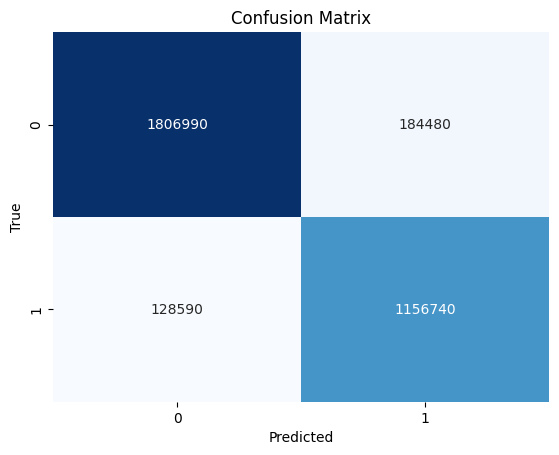

In [48]:
# Compute metrics
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
report = classification_report(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)

# Print metrics
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Classification Report:\n", report)

# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

100%|██████████| 10/10 [00:00<00:00, 14.10it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step


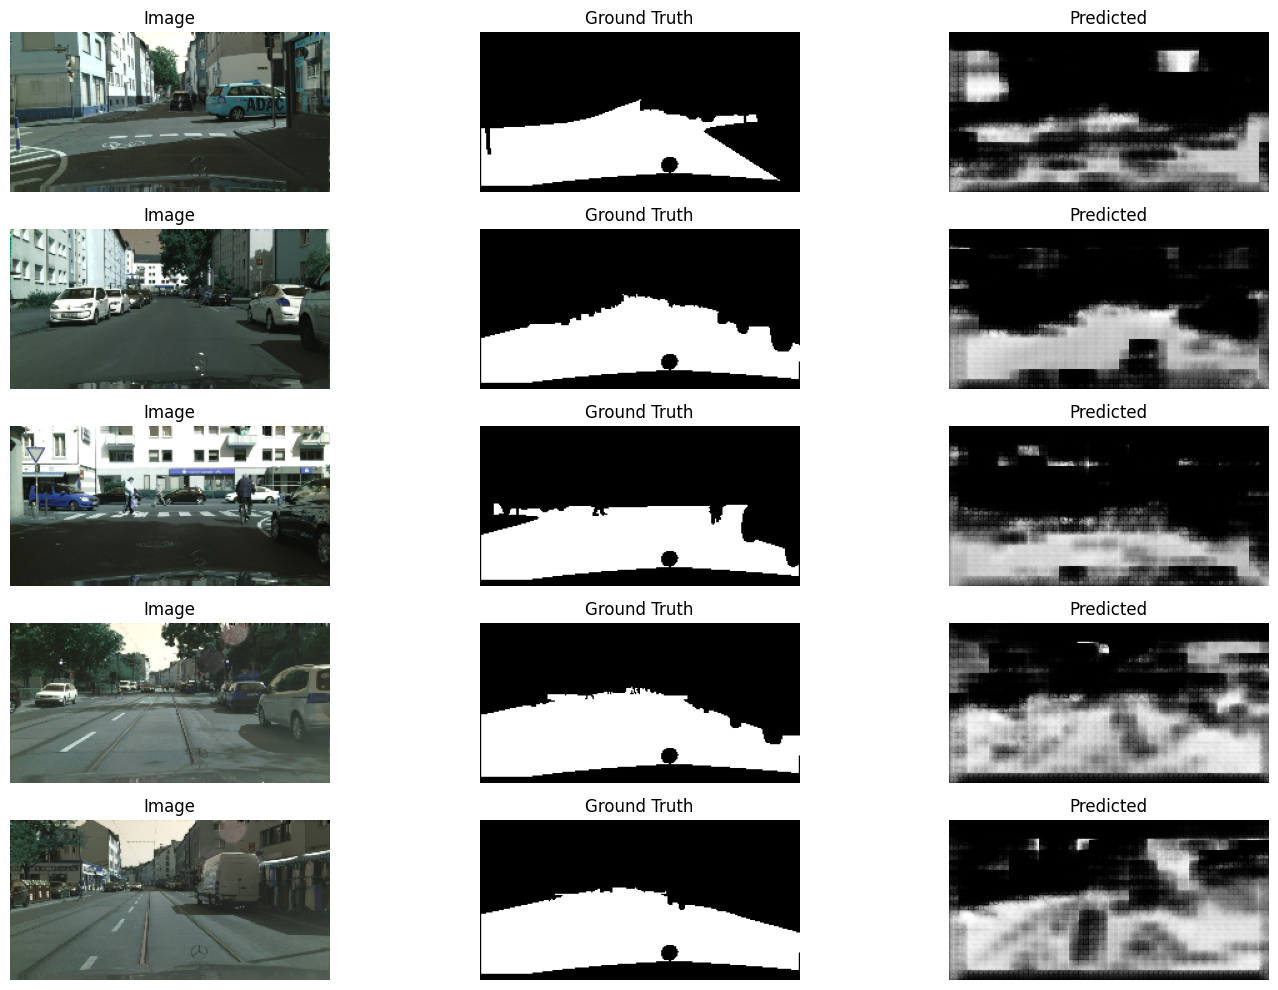

In [49]:
X_val_sample, y_val_sample = next(val_generator)

# Predict on the validation data
y_pred_sample = model.predict(X_val_sample)

def plot_images(X, y_true, y_pred, num_images=5):
    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        plt.subplot(num_images, 3, 3*i + 1)
        plt.imshow(X[i].astype(np.uint8))
        plt.axis('off')
        plt.title("Image")

        plt.subplot(num_images, 3, 3*i + 2)
        plt.imshow(y_true[i].squeeze(), cmap='gray')
        plt.axis('off')
        plt.title("Ground Truth")

        plt.subplot(num_images, 3, 3*i + 3)
        plt.imshow(y_pred[i].squeeze(), cmap='gray')
        plt.axis('off')
        plt.title("Predicted")

    plt.tight_layout()
    plt.show()

plot_images(X_val_sample, y_val_sample, y_pred_sample)

Processing image: ../data/personal_images/IMG_20241205_101544.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


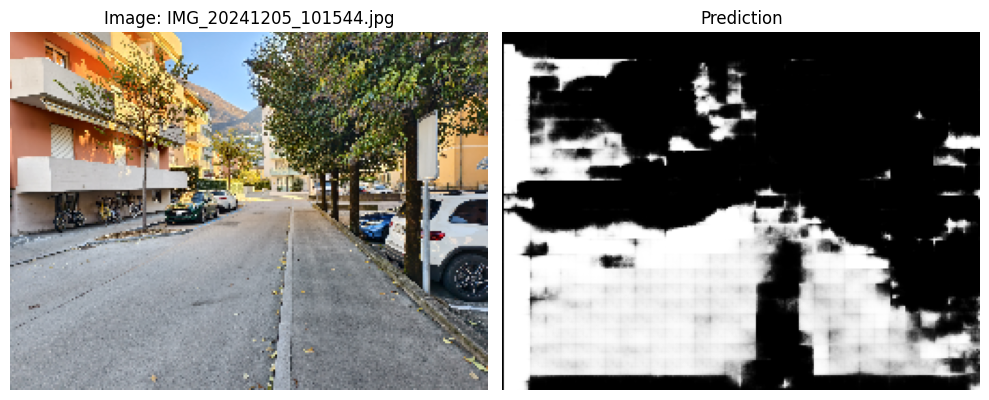

Processing image: ../data/personal_images/IMG_20241205_101454.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


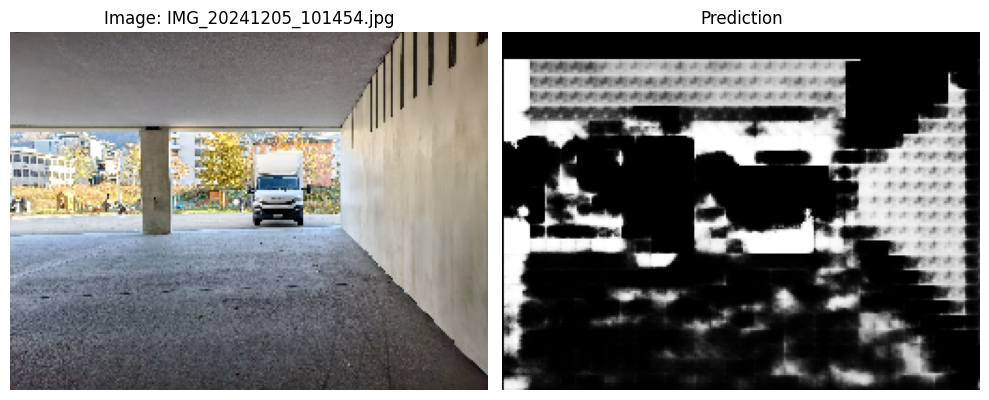

Processing image: ../data/personal_images/IMG_20241205_101509.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


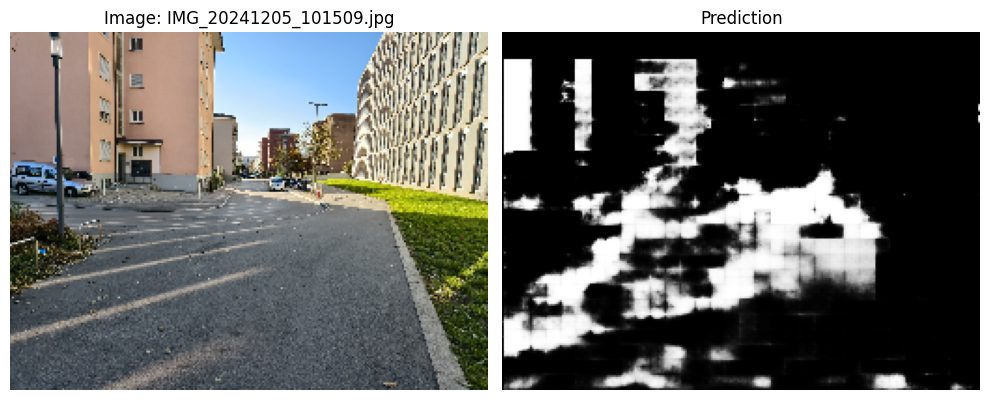

Processing image: ../data/personal_images/IMG_20241205_101535.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


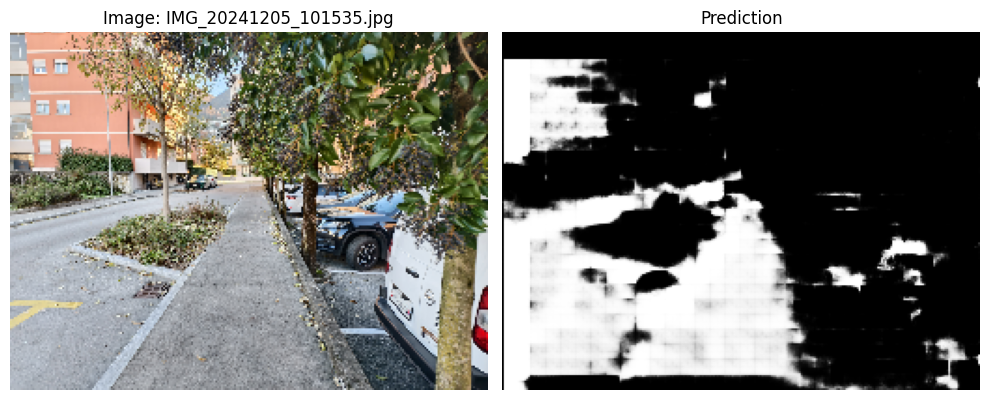

Processing image: ../data/personal_images/IMG_20241205_101519.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


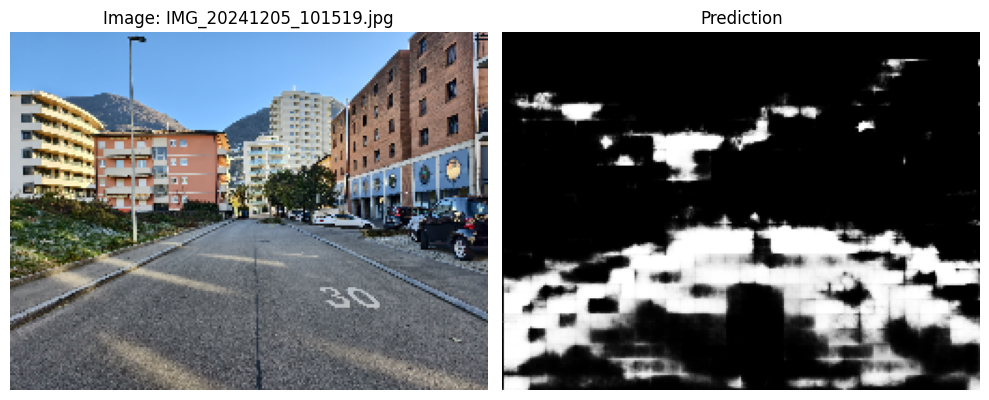

Processing image: ../data/personal_images/IMG_20241205_101701.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


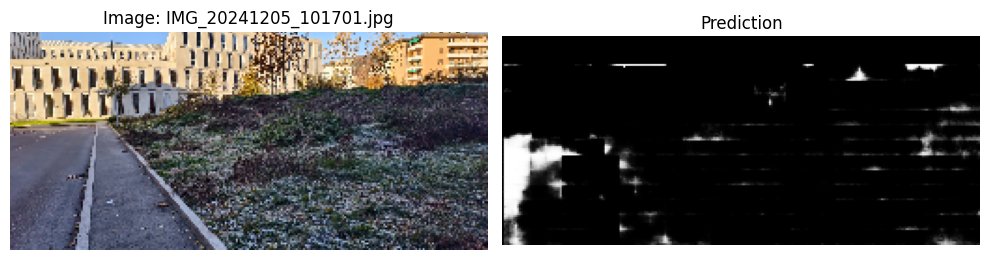

Processing image: ../data/personal_images/IMG_20241205_101703.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


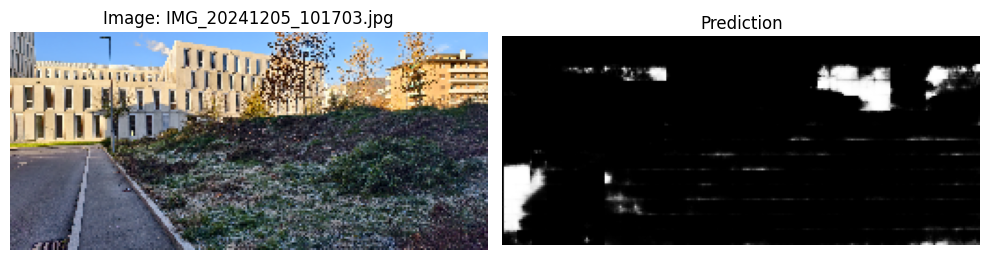

Processing image: ../data/personal_images/IMG_20241205_101717.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


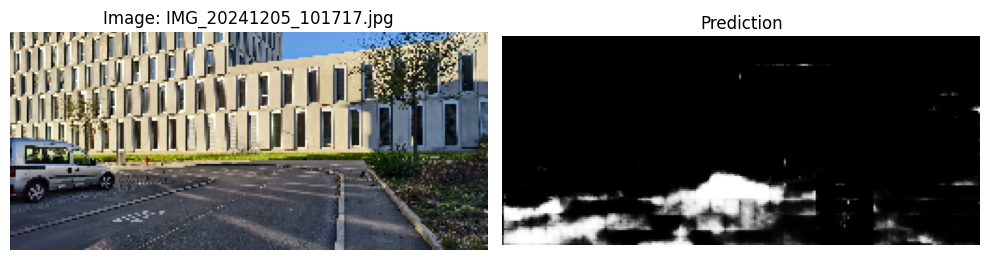

Processing image: ../data/personal_images/IMG_20241205_101528.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


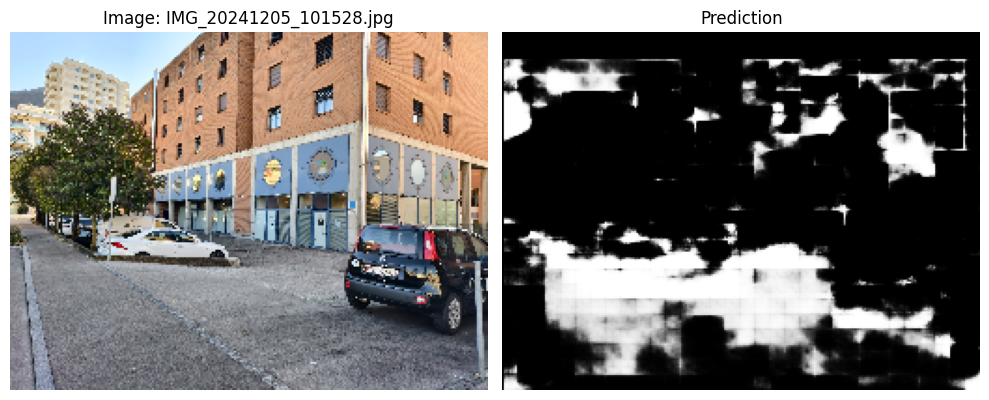

Processing image: ../data/personal_images/IMG_20241205_101706.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


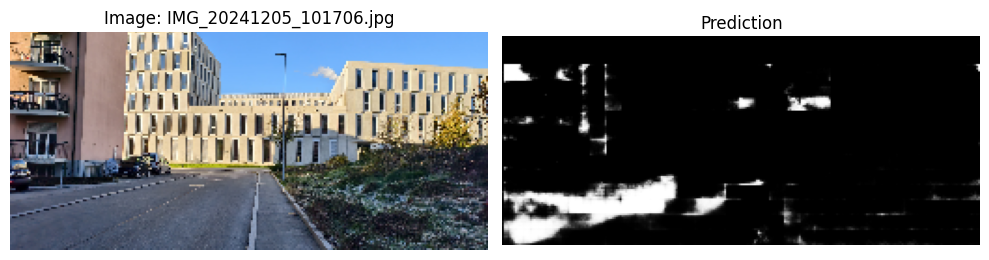

Processing image: ../data/personal_images/IMG_20241205_101511.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


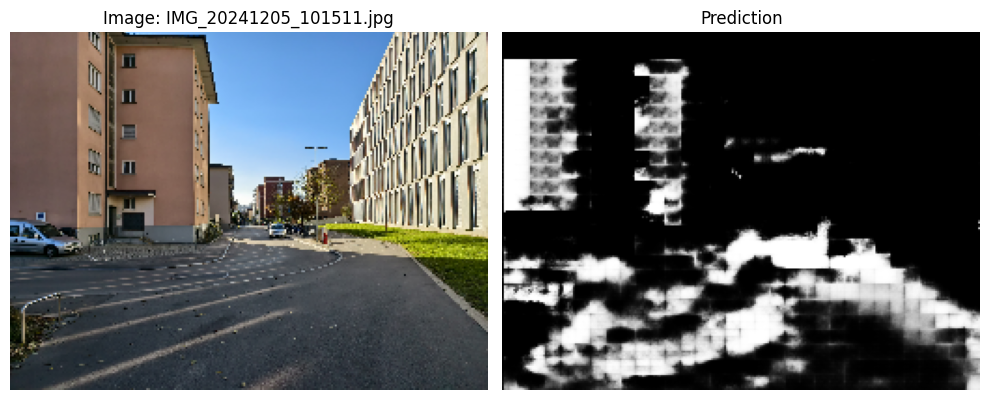

Processing image: ../data/personal_images/IMG_20241205_101604.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


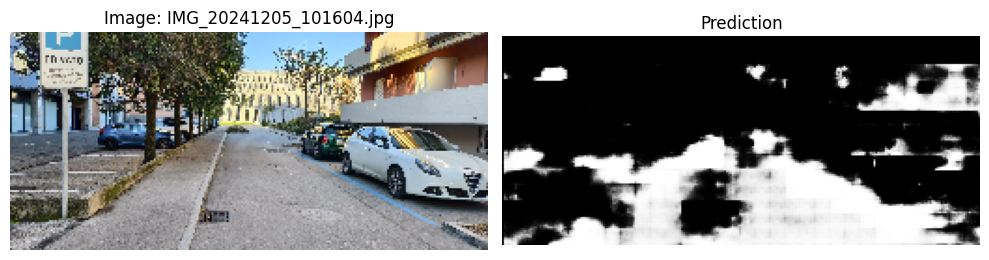

Processing image: ../data/personal_images/IMG_20241205_101558.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


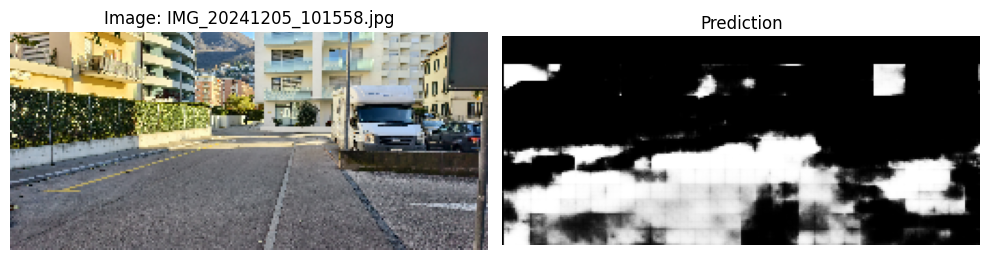

In [67]:
def predict_on_image(model, image_path, target_size=TARGET_SIZE):
    # Load the image
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if image is None:
        raise ValueError(f"Cannot read image from path: {image_path}")
    
    h, w = image.shape[:2]

    # Calculate new height based on aspect ratio
    target_height = int((target_size / w) * h)

    # Resize the image
    image_resized = cv2.resize(image, (target_size, target_height))
    prediction = model.predict(np.expand_dims(image_resized, axis=0))
    return image_resized, prediction

# Define the path to the 'personal_images' folder
image_folder = os.path.join('..','data', 'personal_images')

# Iterate over all images in the 'personal_images' folder
for image_name in os.listdir(image_folder):
    # Check if the file is an image (you can add more formats if needed)
    if image_name.lower().endswith(('.jpg', '.png', '.jpeg')):
        image_path = os.path.join(image_folder, image_name)
        print(f"Processing image: {image_path}")
        
        # Get the image and prediction
        image_resized, prediction = predict_on_image(model, image_path, target_size=TARGET_SIZE)
        
        # Plot the image and prediction
        plt.figure(figsize=(10, 5))
        
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(image_resized, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for proper display
        plt.axis('off')
        plt.title(f"Image: {image_name}")
        
        plt.subplot(1, 2, 2)
        plt.imshow(prediction.squeeze(), cmap='gray')  # Assuming the prediction is a single-channel image
        plt.axis('off')
        plt.title("Prediction")
        
        plt.tight_layout()
        plt.show()
